In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def to_grayscale(image):
    return np.dot(image[..., :3], [0.2989, 0.5870, 0.1140]).astype(np.uint8)

def threshold(image, thresh_value=128):
    binary_image = np.zeros_like(image)
    binary_image[image > thresh_value] = 255
    return binary_image

def create_white_kernel(size=500):
    return np.ones((size, size), dtype=np.uint8) * 255

def match_kernel_optimized(image, kernel, threshold=0.9, step_size=20):
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape
    result = []

    for y in range(0, image_height - kernel_height + 1, step_size):
        for x in range(0, image_width - kernel_width + 1, step_size):
            region = image[y:y + kernel_height, x:x + kernel_width]
            match = np.sum(region == kernel) / (kernel_height * kernel_width)
            if match >= threshold:
                result.append((x, y))

    return result

def draw_rectangle(image, top_left, width, height, color=(0, 255, 0)):
    x, y = top_left
    image[y, x:x + width] = color
    image[y + height - 1, x:x + width] = color
    image[y:y + height, x] = color
    image[y:y + height, x + width - 1] = color
    return image

def draw_red_dot(image, center, radius=5, color=(0, 0, 255)):
    x, y = center
    for i in range(-radius, radius + 1):
        for j in range(-radius, radius + 1):
            if i**2 + j**2 <= radius**2:
                if 0 <= y + i < image.shape[0] and 0 <= x + j < image.shape[1]:
                    image[y + i, x + j] = color
    return image


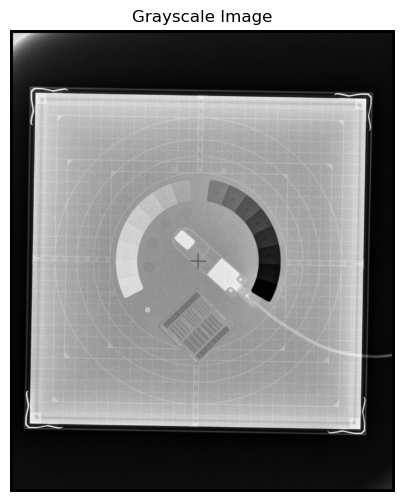

In [3]:
input_image_path = r"PNG\0.8mAs.png"
input_image = cv2.imread(input_image_path)

if input_image is None:
    print("Error: Could not read the image. Please check the path and filename.")
else:
    grayscale_image = to_grayscale(input_image)

    plt.figure(figsize=(6, 6))
    plt.imshow(grayscale_image, cmap='gray')
    plt.title('Grayscale Image')
    plt.axis('off')
    plt.show()


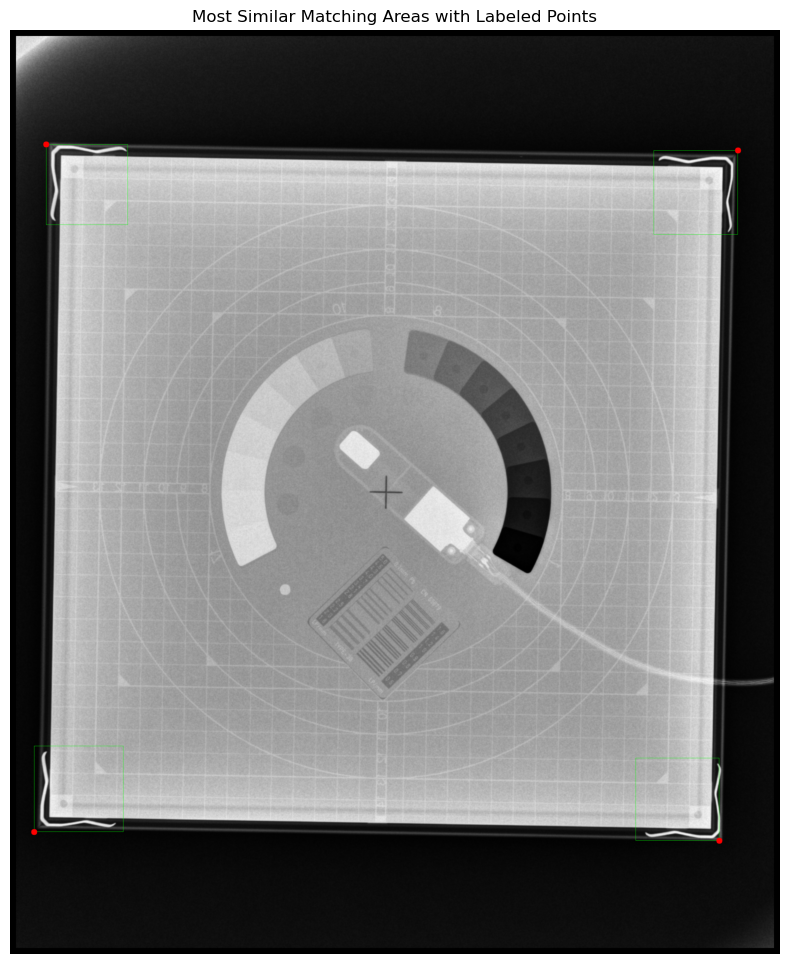

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Function to threshold the grayscale image
def threshold(image, thresh_value=128):
    binary_image = np.zeros_like(image)
    binary_image[image > thresh_value] = 255
    return binary_image

# Function to draw rectangles manually
def draw_rectangle(image, top_left, width, height, color=(0, 255, 0)):
    x, y = top_left
    image[y, x:x + width] = color
    image[y + height - 1, x:x + width] = color
    image[y:y + height, x] = color
    image[y:y + height, x + width - 1] = color
    return image

# Function to draw a red dot
def draw_red_dot(image, center, radius=5, color=(0, 0, 255)):
    x, y = center
    for i in range(-radius, radius + 1):
        for j in range(-radius, radius + 1):
            if i**2 + j**2 <= radius**2:
                if 0 <= y + i < image.shape[0] and 0 <= x + j < image.shape[1]:
                    image[y + i, x + j] = color
    return image

# Load the input image
input_image_path = r"PNG\0.8mAs.png"
input_image = cv2.imread(input_image_path)

# List of kernel images with their descriptive names
kernel_images_info = [
    ("Left_Top_KERNEL.png", "top_left"),
    ("Right_Top_KERNEL.png", "top_right"),
    ("Left_Bottom_KERNEL.png", "bottom_left"),
    ("Right_Bottom_KERNEL.png", "bottom_right")
]

# Convert the input image to grayscale and threshold it
if input_image is None:
    print("Error: Could not read the input image. Please check the path and filename.")
else:
    grayscale_image = np.dot(input_image[..., :3], [0.2989, 0.5870, 0.1140]).astype(np.uint8)
    threshold_value = 128
    binary_image = threshold(grayscale_image, thresh_value=threshold_value)

    # Iterate through each kernel image and perform matching
    output_image = input_image.copy()
    for kernel_image_path, position_type in kernel_images_info:
        kernel_image = cv2.imread(kernel_image_path, cv2.IMREAD_GRAYSCALE)

        if kernel_image is None:
            print(f"Error: Could not read kernel image {kernel_image_path}.")
            continue

        template_height, template_width = kernel_image.shape
        max_similarity = -1
        best_match_position = (0, 0)

        # Sliding window to find the best match with highest similarity
        step_size = 20
        for y in range(0, binary_image.shape[0] - template_height + 1, step_size):
            for x in range(0, binary_image.shape[1] - template_width + 1, step_size):
                region = binary_image[y:y + template_height, x:x + template_width]
                match_score = np.sum(region == kernel_image) / (template_height * template_width)

                if match_score > max_similarity:
                    max_similarity = match_score
                    best_match_position = (x, y)

        # Determine the specific point based on kernel type
        if position_type == "top_left":
            point = best_match_position  # top-left corner
        elif position_type == "top_right":
            point = (best_match_position[0] + template_width, best_match_position[1])  # top-right corner
        elif position_type == "bottom_left":
            point = (best_match_position[0], best_match_position[1] + template_height)  # bottom-left corner
        elif position_type == "bottom_right":
            point = (best_match_position[0] + template_width, best_match_position[1] + template_height)  # bottom-right corner

        # Draw the best matching area with a green rectangle
        output_image = draw_rectangle(output_image, best_match_position, template_width, template_height, color=(0, 255, 0))
        
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Function to threshold the grayscale image
def threshold(image, thresh_value=128):
    binary_image = np.zeros_like(image)
    binary_image[image > thresh_value] = 255
    return binary_image

# Function to draw rectangles manually
def draw_rectangle(image, top_left, width, height, color=(0, 255, 0)):
    x, y = top_left
    image[y, x:x + width] = color
    image[y + height - 1, x:x + width] = color
    image[y:y + height, x] = color
    image[y:y + height, x + width - 1] = color
    return image

# Function to draw a red dot
def draw_red_dot(image, center, radius=5, color=(0, 0, 255)):
    x, y = center
    for i in range(-radius, radius + 1):
        for j in range(-radius, radius + 1):
            if i**2 + j**2 <= radius**2:
                if 0 <= y + i < image.shape[0] and 0 <= x + j < image.shape[1]:
                    image[y + i, x + j] = color
    return image

# Load the input image
input_image_path = r"PNG\0.8mAs.png"
input_image = cv2.imread(input_image_path)

# List of kernel images with their descriptive names
kernel_images_info = [
    ("Left_Top_KERNEL.png", "top_left"),
    ("Right_Top_KERNEL.png", "top_right"),
    ("Left_Bottom_KERNEL.png", "bottom_left"),
    ("Right_Bottom_KERNEL.png", "bottom_right")
]

# Convert the input image to grayscale and threshold it
if input_image is None:
    print("Error: Could not read the input image. Please check the path and filename.")
else:
    grayscale_image = np.dot(input_image[..., :3], [0.2989, 0.5870, 0.1140]).astype(np.uint8)
    threshold_value = 128
    binary_image = threshold(grayscale_image, thresh_value=threshold_value)

    # Iterate through each kernel image and perform matching
    output_image = input_image.copy()
    corner_points = {}

    for kernel_image_path, position_type in kernel_images_info:
        kernel_image = cv2.imread(kernel_image_path, cv2.IMREAD_GRAYSCALE)

        if kernel_image is None:
            print(f"Error: Could not read kernel image {kernel_image_path}.")
            continue

        template_height, template_width = kernel_image.shape
        max_similarity = -1
        best_match_position = (0, 0)

        # Sliding window to find the best match with highest similarity
        step_size = 20
        for y in range(0, binary_image.shape[0] - template_height + 1, step_size):
            for x in range(0, binary_image.shape[1] - template_width + 1, step_size):
                region = binary_image[y:y + template_height, x:x + template_width]
                match_score = np.sum(region == kernel_image) / (template_height * template_width)

                if match_score > max_similarity:
                    max_similarity = match_score
                    best_match_position = (x, y)

        # Determine the specific point based on kernel type
        if position_type == "top_left":
            point = best_match_position  # top-left corner
        elif position_type == "top_right":
            point = (best_match_position[0] + template_width, best_match_position[1])  # top-right corner
        elif position_type == "bottom_left":
            point = (best_match_position[0], best_match_position[1] + template_height)  # bottom-left corner
        elif position_type == "bottom_right":
            point = (best_match_position[0] + template_width, best_match_position[1] + template_height)  # bottom-right corner

        # Save the specific point
        corner_points[position_type] = point

        # Draw the best matching area with a green rectangle
        output_image = draw_rectangle(output_image, best_match_position, template_width, template_height, color=(0, 255, 0))

        # Mark the specific point with a red dot
        output_image = draw_red_dot(output_image, point, radius=10, color=(0, 0, 255))

    # Display the image with rectangles and red dots
    plt.figure(figsize=(12, 12))
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.title('Most Similar Matching Areas with Labeled Points')
    plt.axis('off')
    plt.show()




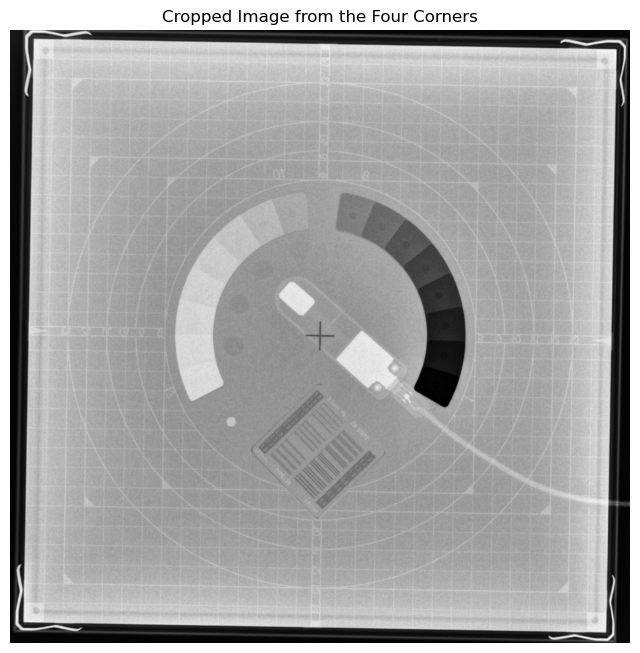

In [5]:
# Get the coordinates for the bounding box
top_left = corner_points['top_left']
top_right = corner_points['top_right']
bottom_left = corner_points['bottom_left']
bottom_right = corner_points['bottom_right']

# Calculate bounding box edges
left_edge = min(top_left[0], bottom_left[0])
right_edge = max(top_right[0], bottom_right[0])
top_edge = min(top_left[1], top_right[1])
bottom_edge = max(bottom_left[1], bottom_right[1])

# Crop the image using NumPy slicing
cropped_image = input_image[top_edge:bottom_edge, left_edge:right_edge]

# Display the cropped image
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
plt.title('Cropped Image from the Four Corners')
plt.axis('off')
plt.show()


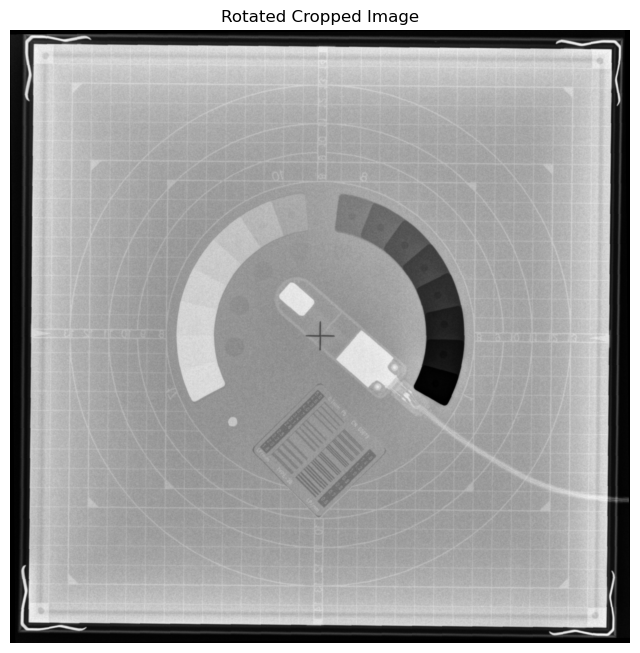

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from math import atan2, degrees, cos, sin

def calculate_rotation_angle(point1, point2):
    delta_y = point2[1] - point1[1]
    delta_x = point2[0] - point1[0]
    angle = atan2(delta_y, delta_x)
    return degrees(angle)

def rotate_image(image, angle):
    (height, width) = image.shape[:2]
    center = (width // 2, height // 2)

    angle_rad = np.deg2rad(angle)
    cos_theta = cos(angle_rad)
    sin_theta = sin(angle_rad)

    new_width = int(abs(height * sin_theta) + abs(width * cos_theta))
    new_height = int(abs(height * cos_theta) + abs(width * sin_theta))

    rotated_image = np.zeros((new_height, new_width, image.shape[2]), dtype=image.dtype)
    offset_x = (new_width - width) // 2
    offset_y = (new_height - height) // 2

    for y in range(new_height):
        for x in range(new_width):
            x_orig = (x - offset_x - center[0]) * cos_theta + (y - offset_y - center[1]) * sin_theta + center[0]
            y_orig = -(x - offset_x - center[0]) * sin_theta + (y - offset_y - center[1]) * cos_theta + center[1]

            if 0 <= x_orig < width and 0 <= y_orig < height:
                rotated_image[y, x] = image[int(y_orig), int(x_orig)]

    return rotated_image

top_left = corner_points['top_left']
top_right = corner_points['top_right']
bottom_left = corner_points['bottom_left']
bottom_right = corner_points['bottom_right']

# Calculate bounding box edges
left_edge = min(top_left[0], bottom_left[0])
right_edge = max(top_right[0], bottom_right[0])
top_edge = min(top_left[1], top_right[1])
bottom_edge = max(bottom_left[1], bottom_right[1])

# Crop the image using NumPy slicing
cropped_image = input_image[top_edge:bottom_edge, left_edge:right_edge]

# Calculate the rotation angle for the cropped image
rotation_angle = calculate_rotation_angle(top_left, top_right)

# Rotate the cropped image by the calculated angle
rotated_cropped_image = rotate_image(cropped_image, -rotation_angle)

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(rotated_cropped_image, cv2.COLOR_BGR2RGB))
plt.title('Rotated Cropped Image')
plt.axis('off')
plt.show()


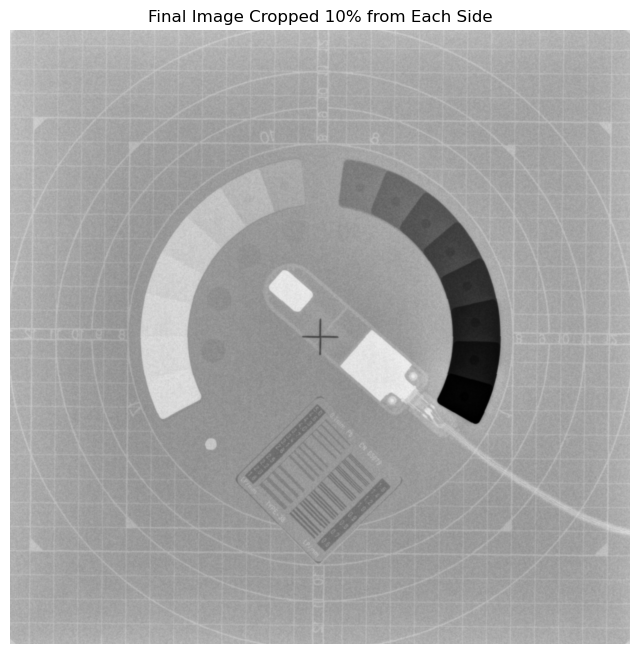

In [7]:
# Calculate the 10% margin to crop from each side
height, width = rotated_cropped_image.shape[:2]
margin_x = int(width * 0.10)
margin_y = int(height * 0.10)

# Crop 10% from each side of the rotated image
cropped_final_image = rotated_cropped_image[margin_y:height - margin_y, margin_x:width - margin_x]

# Display the final cropped image
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(cropped_final_image, cv2.COLOR_BGR2RGB))
plt.title('Final Image Cropped 10% from Each Side')
plt.axis('off')
plt.show()


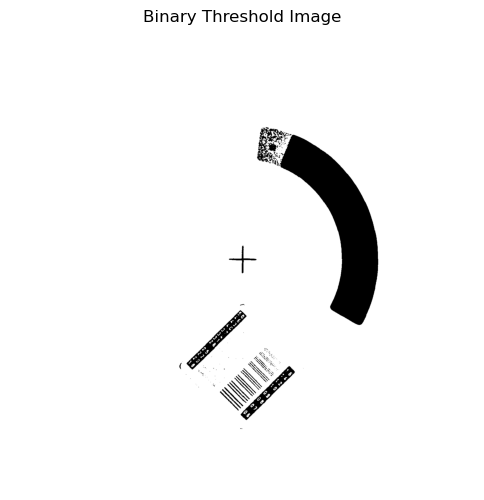

In [8]:
# Convert the thresholded image to grayscale and save it
threshold_value = 125
cropped_binary_image = threshold(cropped_final_image, thresh_value=threshold_value)

# Display the thresholded image using matplotlib
plt.figure(figsize=(6, 6))
plt.imshow(cropped_binary_image, cmap='gray')
plt.title('Binary Threshold Image')
plt.axis('off')
plt.show()


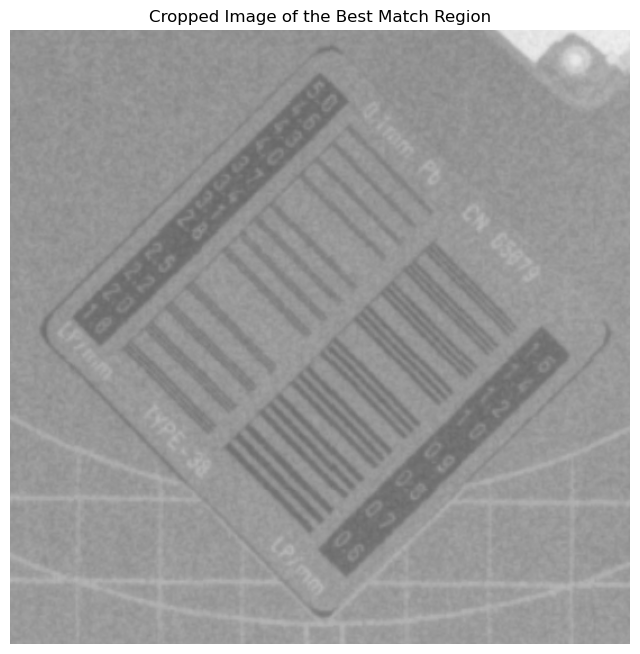

In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Assume `to_grayscale` function is already defined
# def to_grayscale(image):
#     return np.dot(image[..., :3], [0.2989, 0.5870, 0.1140]).astype(np.uint8)

# Load the new phantom kernel
phantom_kernel_path = 'phantom-kernel.png'
phantom_kernel = cv2.imread(phantom_kernel_path)  # Load in normal RGB
if phantom_kernel is None:
    print("Error: Could not read the phantom kernel image. Please check the path and filename.")
else:
    # Convert phantom kernel to grayscale using the provided function
    phantom_kernel_gray = to_grayscale(phantom_kernel)
    cropped_binary_image = to_grayscale(cropped_binary_image)

    # Assume `cropped_binary_image` is already defined
    # Perform template matching on the cropped binary image
    template_height, template_width = phantom_kernel_gray.shape
    max_similarity = -1
    best_match_position = None

    # Perform template matching to search for the highest similarity
    step_size = 10
    for y in range(0, cropped_binary_image.shape[0] - template_height + 1, step_size):
        for x in range(0, cropped_binary_image.shape[1] - template_width + 1, step_size):
            region = cropped_binary_image[y:y + template_height, x:x + template_width]

            # Compute match score
            match_score = np.sum(region == phantom_kernel_gray) / (template_height * template_width)

            # Update the best match if current match score is higher
            if match_score > max_similarity:
                max_similarity = match_score
                best_match_position = (x, y)

    # Check if a best match was found
    if best_match_position is not None:
        # Extract the coordinates of the best match
        x_best, y_best = best_match_position

        # Crop the image using the best match coordinates
        cropped_best_match = cropped_final_image[y_best:y_best + template_height, x_best:x_best + template_width]

        # Display the cropped best match region
        plt.figure(figsize=(8, 8))
        plt.imshow(cv2.cvtColor(cropped_best_match, cv2.COLOR_BGR2RGB))
        plt.title('Cropped Image of the Best Match Region')
        plt.axis('off')
        plt.show()
    else:
        print("No matching regions found.")


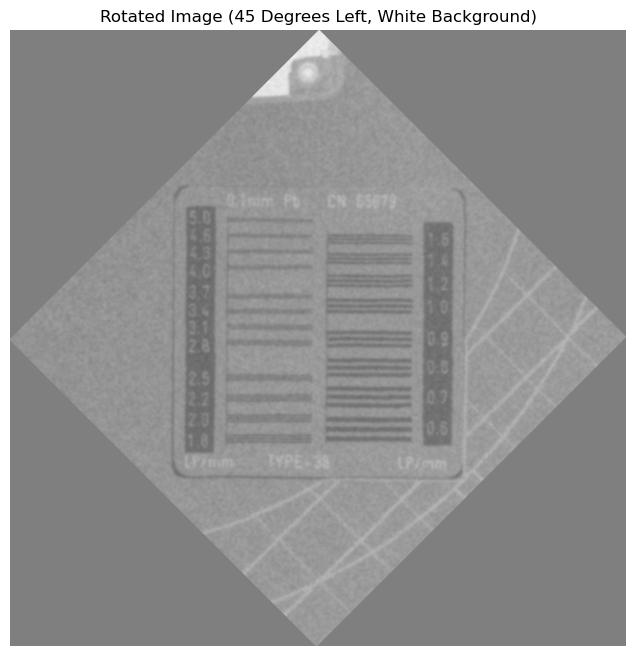

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from math import cos, sin, radians

def rotate_image(image, angle):
    angle_rad = radians(angle)
    cos_theta = cos(angle_rad)
    sin_theta = sin(angle_rad)
    
    (h, w) = image.shape[:2]

    # Calculate the new dimensions of the rotated image
    new_w = int(abs(h * sin_theta) + abs(w * cos_theta))
    new_h = int(abs(h * cos_theta) + abs(w * sin_theta))

    # Calculate the center of the original image
    center_x, center_y = w // 2, h // 2

    # Create an empty image for the result, initialize with white (255)
    rotated_image = np.ones((new_h, new_w, image.shape[2]), dtype=image.dtype) * 127

    # Calculate the center of the new image
    new_center_x, new_center_y = new_w // 2, new_h // 2

    # Rotate each pixel in the new image to find its corresponding location in the original image
    for y in range(new_h):
        for x in range(new_w):
            # Calculate coordinates relative to the center of the new image
            x_shifted = x - new_center_x
            y_shifted = y - new_center_y

            # Calculate the corresponding original coordinates
            orig_x = int(center_x + (x_shifted * cos_theta + y_shifted * sin_theta))
            orig_y = int(center_y + (-x_shifted * sin_theta + y_shifted * cos_theta))

            # If the original coordinates are within bounds, copy the pixel value
            if 0 <= orig_x < w and 0 <= orig_y < h:
                rotated_image[y, x] = image[orig_y, orig_x]

    return rotated_image

# Rotate the cropped best match region by 45 degrees to the left
rotated_cropped_image = rotate_image(cropped_best_match, angle=-45)

# Display the rotated image
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(rotated_cropped_image, cv2.COLOR_BGR2RGB))
plt.title('Rotated Image (45 Degrees Left, White Background)')
plt.axis('off')
plt.show()


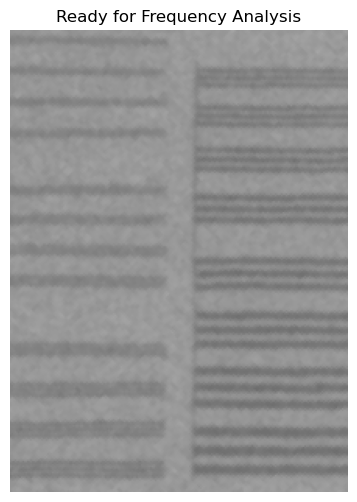

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

# The image to be cropped (rotated_cropped_image)
image = rotated_cropped_image.copy()
clone = image.copy()  # A clone to reset the image after drawing the rectangle

# Variables to store the starting point and ending point of the rectangle
start_point = None
end_point = None
drawing = False

# Mouse callback function
def draw_rectangle(event, x, y, flags, param):
    global start_point, end_point, drawing, image

    if event == cv2.EVENT_LBUTTONDOWN:
        # Start drawing, record the starting point
        start_point = (x, y)
        drawing = True

    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            # If drawing, display the current rectangle being dragged
            image = clone.copy()
            cv2.rectangle(image, start_point, (x, y), (0, 255, 0), 2)
            cv2.imshow("Select Rectangle to Crop", image)

    elif event == cv2.EVENT_LBUTTONUP:
        # Finish drawing, record the ending point and crop the region
        end_point = (x, y)
        drawing = False
        image = clone.copy()
        cv2.rectangle(image, start_point, end_point, (0, 255, 0), 2)
        cv2.imshow("Select Rectangle to Crop", image)
        crop_image_by_rectangle(start_point, end_point)

# Function to perform cropping based on selected rectangle points
def crop_image_by_rectangle(start, end):
    global image
    # Determine the bounding box coordinates
    x1, y1 = start
    x2, y2 = end

    # Ensure the coordinates are valid regardless of the drag direction
    x_min = min(x1, x2)
    x_max = max(x1, x2)
    y_min = min(y1, y2)
    y_max = max(y1, y2)

    # Crop the image based on the defined bounding box
    cropped = clone[y_min:y_max, x_min:x_max]

    # Show the cropped image
    cv2.imshow("Cropped Image", cropped)
    cv2.waitKey(1000)  # Wait for 1 second

    # Close the windows
    cv2.destroyAllWindows()

    # Save the cropped image
    cropped_image_path = "ready_to_freq_analysis.png"
    cv2.imwrite(cropped_image_path, cropped)

    # Plot the cropped image in Jupyter
    plot_image_in_jupyter(cropped_image_path)

# Function to plot the image in Jupyter using matplotlib
def plot_image_in_jupyter(image_path):
    # Load the saved image
    cropped_image = cv2.imread(image_path)
    cropped_image_rgb = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)

    # Plot the image using matplotlib
    plt.figure(figsize=(6, 6))
    plt.imshow(cropped_image_rgb)
    plt.title("Ready for Frequency Analysis")
    plt.axis('off')
    plt.show()

# Create a window and set the mouse callback function
cv2.imshow("Select Rectangle to Crop", image)
cv2.setMouseCallback("Select Rectangle to Crop", draw_rectangle)

# Wait until the user selects the points and the window is closed
cv2.waitKey(0)
cv2.destroyAllWindows()


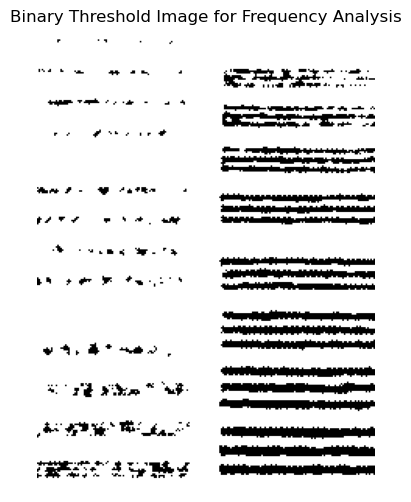

In [13]:
# Load the cropped image that is ready for analysis
image_path = "ready_to_freq_analysis.png"
cropped_image = cv2.imread(image_path)
cropped_image_gray = to_grayscale(cropped_image)

# Apply the threshold function already defined in Jupyter
threshold_value = 128  # Adjust as needed
binary_image = threshold(cropped_image_gray, thresh_value=threshold_value)

# Plot the binary threshold image in Jupyter
plt.figure(figsize=(6, 6))
plt.imshow(binary_image, cmap='gray')
plt.title('Binary Threshold Image for Frequency Analysis')
plt.axis('off')
plt.show()


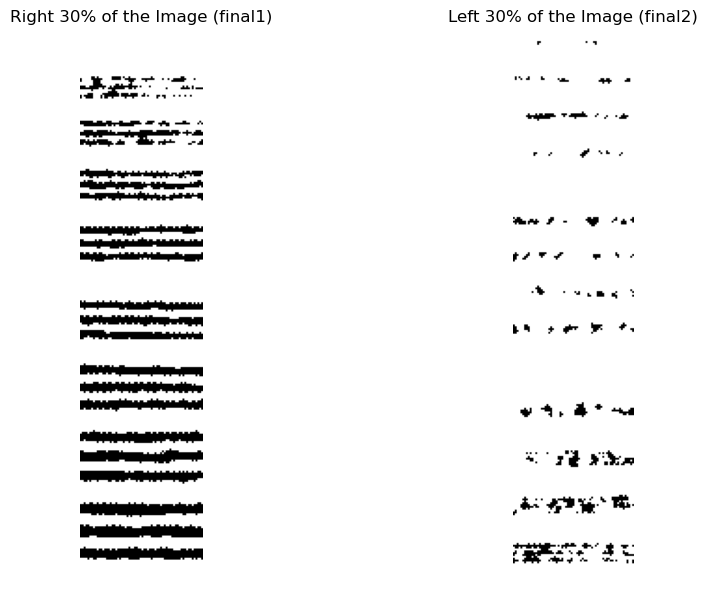

In [14]:
# Get the dimensions of the binary thresholded image
height, width = binary_image.shape

# Calculate the split points for cropping
right_start = int(width * 0.7)  # Start point of right 30%
left_end = int(width * 0.3)  # End point of left 30%

# Crop the right 30% of the image
final1 = binary_image[:, right_start:width]
cv2.imwrite('final1.png', final1)

# Crop the left 30% of the image
final2 = binary_image[:, :left_end]
cv2.imwrite('final2.png', final2)

# Plot the two final images
plt.figure(figsize=(12, 6))

# Plot final1 (right 30%)
plt.subplot(1, 2, 1)
plt.imshow(final1, cmap='gray')
plt.title('Right 30% of the Image (final1)')
plt.axis('off')

# Plot final2 (left 30%)
plt.subplot(1, 2, 2)
plt.imshow(final2, cmap='gray')
plt.title('Left 30% of the Image (final2)')
plt.axis('off')

plt.tight_layout()
plt.show()


In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def analyze_image(image_path):
    """
    Analyzes a binary image for the black-to-total pixel ratio in each horizontal line.

    Parameters:
        image_path (str): Path to the binary image.

    Returns:
        list: A vector containing the black-to-total pixel ratio for each line.
        matplotlib.figure.Figure: The plot showing the black-to-total pixel ratio.
    """
    # Load the image as grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Threshold the image to binary (if not already binary)
    _, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)

    # Analyze the horizontal lines
    height, _ = binary_image.shape
    ratios = []
    for row in range(height):
        total_pixels = binary_image[row].size
        black_pixels = total_pixels - cv2.countNonZero(binary_image[row])
        ratios.append(black_pixels / total_pixels)

    # Generate the plot
    plt.figure(figsize=(8, 6))
    plt.plot(ratios[::-1], range(len(ratios)), label="Black Pixel Ratio")  # Flip for bottom-to-top
    plt.title("Black Pixel Ratio Per Horizontal Line")
    plt.ylabel("Line Index (from bottom)")
    plt.xlabel("Black/Total Pixels")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    return ratios
def analyze_line_groups(ratios, threshold=0.4):
    """
    Analyze the line groups of three and classify them as OK or NOT based on the threshold.

    Parameters:
        ratios (list): The black-to-total pixel ratio vector.
        threshold (float): The ratio threshold to determine significance.

    Returns:
        list: A list of tuples where each tuple contains the group index and the classification (OK or NOT).
    """
    results = []
    for i in range(0, len(ratios), 3):
        group = ratios[i:i+3]
        if len(group) < 3:
            continue  # Ignore incomplete groups
        
        # Check if all lines in the group are below the threshold
        if all(ratio < threshold for ratio in group):
            results.append((i // 3, "OK"))
        else:
            results.append((i // 3, "NOT"))

    return results

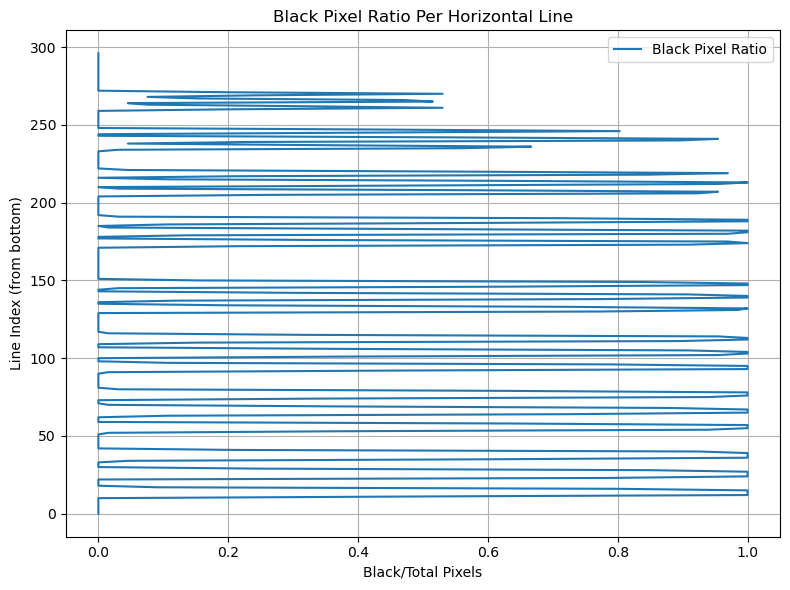

[(0, 'OK'),
 (1, 'OK'),
 (2, 'OK'),
 (3, 'OK'),
 (4, 'OK'),
 (5, 'OK'),
 (6, 'OK'),
 (7, 'OK'),
 (8, 'NOT'),
 (9, 'OK'),
 (10, 'NOT'),
 (11, 'NOT'),
 (12, 'OK'),
 (13, 'OK'),
 (14, 'OK'),
 (15, 'OK'),
 (16, 'NOT'),
 (17, 'OK'),
 (18, 'NOT'),
 (19, 'OK'),
 (20, 'NOT'),
 (21, 'OK'),
 (22, 'OK'),
 (23, 'OK'),
 (24, 'OK'),
 (25, 'NOT'),
 (26, 'NOT'),
 (27, 'NOT'),
 (28, 'NOT'),
 (29, 'NOT'),
 (30, 'NOT'),
 (31, 'OK'),
 (32, 'OK'),
 (33, 'OK'),
 (34, 'OK'),
 (35, 'NOT'),
 (36, 'NOT'),
 (37, 'NOT'),
 (38, 'NOT'),
 (39, 'OK'),
 (40, 'NOT'),
 (41, 'NOT'),
 (42, 'OK'),
 (43, 'OK'),
 (44, 'OK'),
 (45, 'OK'),
 (46, 'OK'),
 (47, 'OK'),
 (48, 'OK'),
 (49, 'NOT'),
 (50, 'NOT'),
 (51, 'NOT'),
 (52, 'NOT'),
 (53, 'OK'),
 (54, 'NOT'),
 (55, 'NOT'),
 (56, 'OK'),
 (57, 'OK'),
 (58, 'OK'),
 (59, 'OK'),
 (60, 'NOT'),
 (61, 'NOT'),
 (62, 'OK'),
 (63, 'NOT'),
 (64, 'NOT'),
 (65, 'OK'),
 (66, 'NOT'),
 (67, 'NOT'),
 (68, 'NOT'),
 (69, 'OK'),
 (70, 'OK'),
 (71, 'OK'),
 (72, 'NOT'),
 (73, 'NOT'),
 (74, 'OK'),
 (

In [27]:
raitosoffin1 = analyze_image("final1.png")
analyze_line_groups(raitosoffin1)

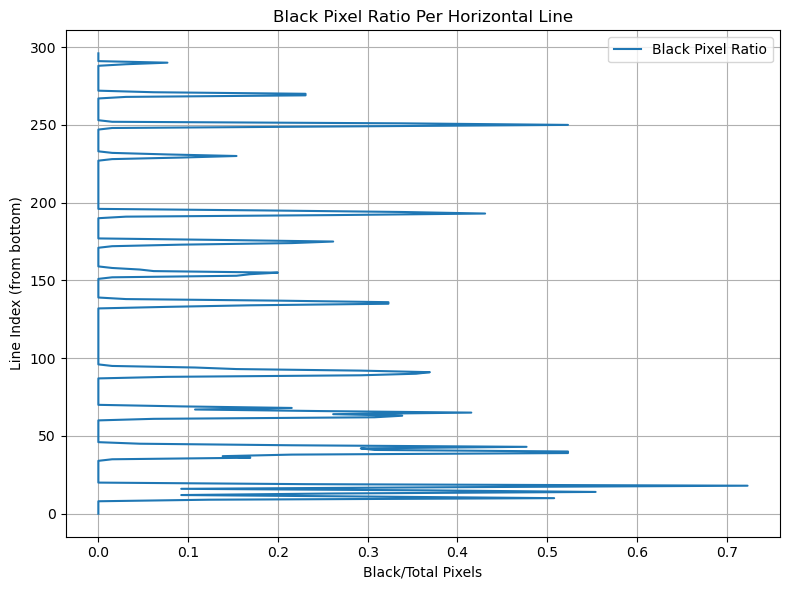

In [26]:
raitosoffin2 = analyze_image("final2.png")